## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/ml-latest-small/'
#path='data/ml-latest/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [5]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


In [6]:
mtitles = movies['title']; mtitles
#mtitles[topMovies[:20]]

0                                        Toy Story (1995)
1                                          Jumanji (1995)
2                                 Grumpier Old Men (1995)
3                                Waiting to Exhale (1995)
4                      Father of the Bride Part II (1995)
5                                             Heat (1995)
6                                          Sabrina (1995)
7                                     Tom and Huck (1995)
8                                     Sudden Death (1995)
9                                        GoldenEye (1995)
10                         American President, The (1995)
11                     Dracula: Dead and Loving It (1995)
12                                           Balto (1995)
13                                           Nixon (1995)
14                                Cutthroat Island (1995)
15                                          Casino (1995)
16                           Sense and Sensibility (1995)
17            

## Collaborative filtering

In [7]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4   # Weight decay
n_factors = 50  # size of embedding matrix

In [8]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [9]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True)

A Jupyter Widget

[ 0.       0.8287   0.83035]                                    
[ 1.       0.65723  0.867  ]                                    
[ 2.       0.33583  0.82325]                                    



Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [10]:
math.sqrt(0.82999)

0.9110378696848995

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [11]:
preds = learn.predict()

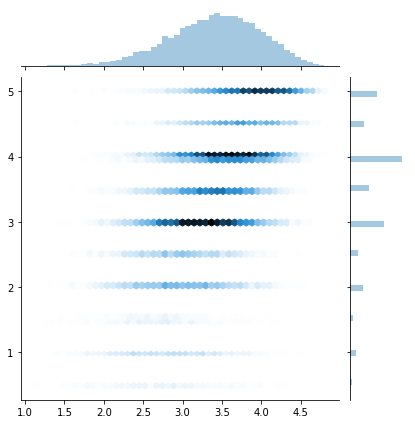

In [12]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## 4. Analyze results

### 4.1 Movie bias

In [13]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

`learn.models.model` is the pytorch model. `learn.model` is fastai shortcut. Below it shows the actual layers.

In [14]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

V() converts a Tensor into a Variable. Required because models use Variables (for derivatives tracking) 

In [58]:
V(topMovieIdx)  # Variable in GPU of size 3000

Variable containing:
 0.6164
 0.5506
 0.9140
   ⋮    
 0.2659
-0.0116
 0.1408
[torch.cuda.FloatTensor of size 3000x1 (GPU 0)]

In [59]:
m.ib(V(topMovieIdx))   

Variable containing:
 0.6164
 0.5506
 0.9140
   ⋮    
 0.2659
-0.0116
 0.1408
[torch.cuda.FloatTensor of size 3000x1 (GPU 0)]

`to_np` is a fastai shortcut to translate to numpy regardles of wheather it is or not in GPU

In [15]:
movie_bias = to_np(m.ib(V(topMovieIdx)))   

Jeffrey: *My approach is use numpy unless we need GPU or derivatives, in which case we use pytorch*

To move a variable to the CPU, just append `.cpu()`

In [16]:
movie_bias

array([[ 0.6164 ],
       [ 0.55062],
       [ 0.91399],
       ..., 
       [ 0.26592],
       [-0.01165],
       [ 0.14076]], dtype=float32)

In [17]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [18]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.58266288, 'Battlefield Earth (2000)'),
 (-0.50508034, 'Super Mario Bros. (1993)'),
 (-0.47341383, 'Inspector Gadget (1999)'),
 (-0.44508043, 'Anaconda (1997)'),
 (-0.44424161, 'Speed 2: Cruise Control (1997)'),
 (-0.42631733, 'Wild Wild West (1999)'),
 (-0.41520324, 'Blade: Trinity (2004)'),
 (-0.41392973, "Joe's Apartment (1996)"),
 (-0.40731791, 'Dungeons & Dragons (2000)'),
 (-0.40726724, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.39425486, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.39089262, 'Max Payne (2008)'),
 (-0.38949946, 'Karate Kid, Part III, The (1989)'),
 (-0.38677719, 'Howard the Duck (1986)'),
 (-0.38610214, 'Batman & Robin (1997)')]

In [19]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.58266288, 'Battlefield Earth (2000)'),
 (-0.50508034, 'Super Mario Bros. (1993)'),
 (-0.47341383, 'Inspector Gadget (1999)'),
 (-0.44508043, 'Anaconda (1997)'),
 (-0.44424161, 'Speed 2: Cruise Control (1997)'),
 (-0.42631733, 'Wild Wild West (1999)'),
 (-0.41520324, 'Blade: Trinity (2004)'),
 (-0.41392973, "Joe's Apartment (1996)"),
 (-0.40731791, 'Dungeons & Dragons (2000)'),
 (-0.40726724, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.39425486, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.39089262, 'Max Payne (2008)'),
 (-0.38949946, 'Karate Kid, Part III, The (1989)'),
 (-0.38677719, 'Howard the Duck (1986)'),
 (-0.38610214, 'Batman & Robin (1997)')]

In [20]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(0.91398549, 'Shawshank Redemption, The (1994)'),
 (0.67100966, 'Godfather, The (1972)'),
 (0.64740658, "Schindler's List (1993)"),
 (0.61639768, 'Forrest Gump (1994)'),
 (0.61566818, 'Fugitive, The (1993)'),
 (0.6061511, '12 Angry Men (1957)'),
 (0.58749104, 'Memento (2000)'),
 (0.58747327, 'Silence of the Lambs, The (1991)'),
 (0.57252252, 'Princess Bride, The (1987)'),
 (0.57204717, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.56859028, 'African Queen, The (1951)'),
 (0.56712836, 'Rear Window (1954)'),
 (0.56452423, 'All About Eve (1950)'),
 (0.56390488, 'Usual Suspects, The (1995)'),
 (0.56225938, 'How to Train Your Dragon (2010)')]

### 4.2 Embedding interpretation

We can now do the same thing for the embeddings.

In [21]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [23]:
movie_pca.shape

(3, 3000)

In [24]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [25]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.041991595, 'Battlefield Earth (2000)'),
 (0.040886581, 'Home Alone 3 (1997)'),
 (0.040214229, 'Billy Jack (1971)'),
 (0.038230732, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.037265163, 'Anaconda (1997)'),
 (0.037196212, 'Karate Kid, Part III, The (1989)'),
 (0.036899626, 'Howard the Duck (1986)'),
 (0.036283731, 'Max Payne (2008)'),
 (0.036099896, 'Eragon (2006)'),
 (0.035932776, 'Green Lantern (2011)')]

In [26]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.058713648, 'Godfather: Part II, The (1974)'),
 (-0.056317776, 'Goodfellas (1990)'),
 (-0.054824587, 'Modern Times (1936)'),
 (-0.052587882, 'Chinatown (1974)'),
 (-0.052451234, 'On the Waterfront (1954)'),
 (-0.052325666, 'Godfather, The (1972)'),
 (-0.051971219, 'Usual Suspects, The (1995)'),
 (-0.05027841, 'Cool Hand Luke (1967)'),
 (-0.050245196, 'Raging Bull (1980)'),
 (-0.049866747, 'Name of the Rose, The (Name der Rose, Der) (1986)')]

In [27]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [28]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.054720566, 'It Follows (2014)'),
 (0.053045381, 'Piano Teacher, The (La pianiste) (2001)'),
 (0.047197539, 'Where the Wild Things Are (2009)'),
 (0.046518628, 'Amateur (1994)'),
 (0.046100911, 'Eyes Wide Shut (1999)'),
 (0.045311771, 'Battle of Algiers, The (La battaglia di Algeri) (1966)'),
 (0.044561893, 'Mission: Impossible - Rogue Nation (2015)'),
 (0.04431938, 'Zodiac (2007)'),
 (0.043068979, '2001: A Space Odyssey (1968)'),
 (0.043013021, 'Thirty-Two Short Films About Glenn Gould (1993)')]

In [29]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.070955746, 'Sweet Home Alabama (2002)'),
 (-0.065112971, 'Lilo & Stitch (2002)'),
 (-0.060212411, 'Few Good Men, A (1992)'),
 (-0.060053989, '50 First Dates (2004)'),
 (-0.056622364, 'Anchorman 2: The Legend Continues (2013)'),
 (-0.056434616, "March of the Penguins (Marche de l'empereur, La) (2005)"),
 (-0.053872988, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.05357825, 'Sydney (Hard Eight) (1996)'),
 (-0.053549975, 'Lincoln (2012)'),
 (-0.053372752, 'Lake Placid (1999)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

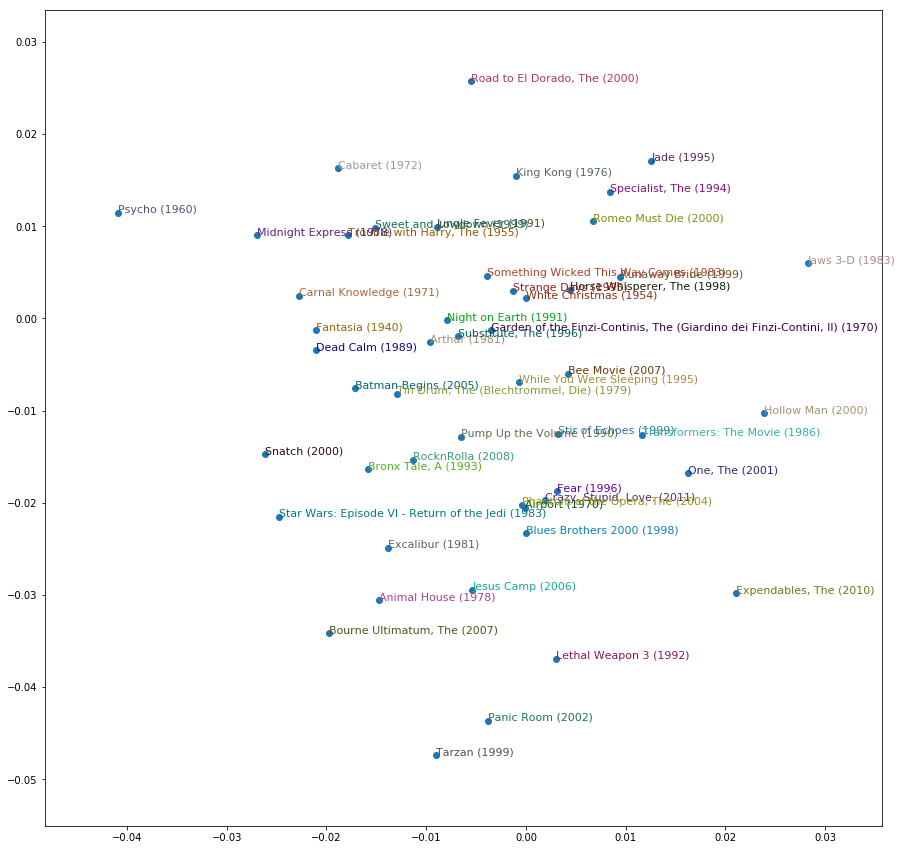

In [30]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [31]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [32]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [33]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [34]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [35]:
model=DotProduct()

In [36]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [37]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [38]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [39]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [40]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [41]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [42]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       1.73717  1.62528]                                   
[ 1.       1.06909  1.29935]                                   
[ 2.       0.9189   1.22477]                                    



In [43]:
set_lrs(opt, 0.01)

In [44]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.69795  1.14939]                                    
[ 1.       0.67957  1.13632]                                    
[ 2.       0.6607   1.12923]                                    



### Bias

In [45]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [46]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [47]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [48]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.82751  0.83756]                                    
[ 1.       0.80097  0.81356]                                    
[ 2.       0.80761  0.80802]                                    



In [49]:
set_lrs(opt, 1e-2)

In [50]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.75668  0.80219]                                    
[ 1.       0.75267  0.80153]                                    
[ 2.       0.75062  0.80073]                                    



### Mini net

nn.Linear already includes a bias

In [51]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [52]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [53]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88323  0.81982]                                    
[ 1.       0.82648  0.80106]                                    
[ 2.       0.78757  0.79521]                                    



In [54]:
set_lrs(opt, 1e-3)

In [55]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.79764  0.79657]                                    
[ 1.       0.81539  0.79518]                                    
[ 2.       0.77738  0.79387]                                    

